In [1]:
# imports
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.Dataset import load_dataset

from IPython.display import Image, display

import numpy as np
from dotenv import load_dotenv
import os

from SAT.classical import solveClassicalSAT
from SAT.fixedPointQuantum import solveFixedQuantunSAT

from qiskit_ibm_runtime import QiskitRuntimeService


/home/lino/cSAT/venv-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the boston housing dataset

In [2]:
data, labels = load_dataset("boston_housing")

In [3]:
# take a subset of the data to speed up the process
data = data[:150, :]

In [4]:
cg = pc(data, indep_test=kci, kernelZ="Polynomial", show_progress=True)

Depth=4, working on node 13: 100%|██████████| 14/14 [00:00<00:00, 205.42it/s]


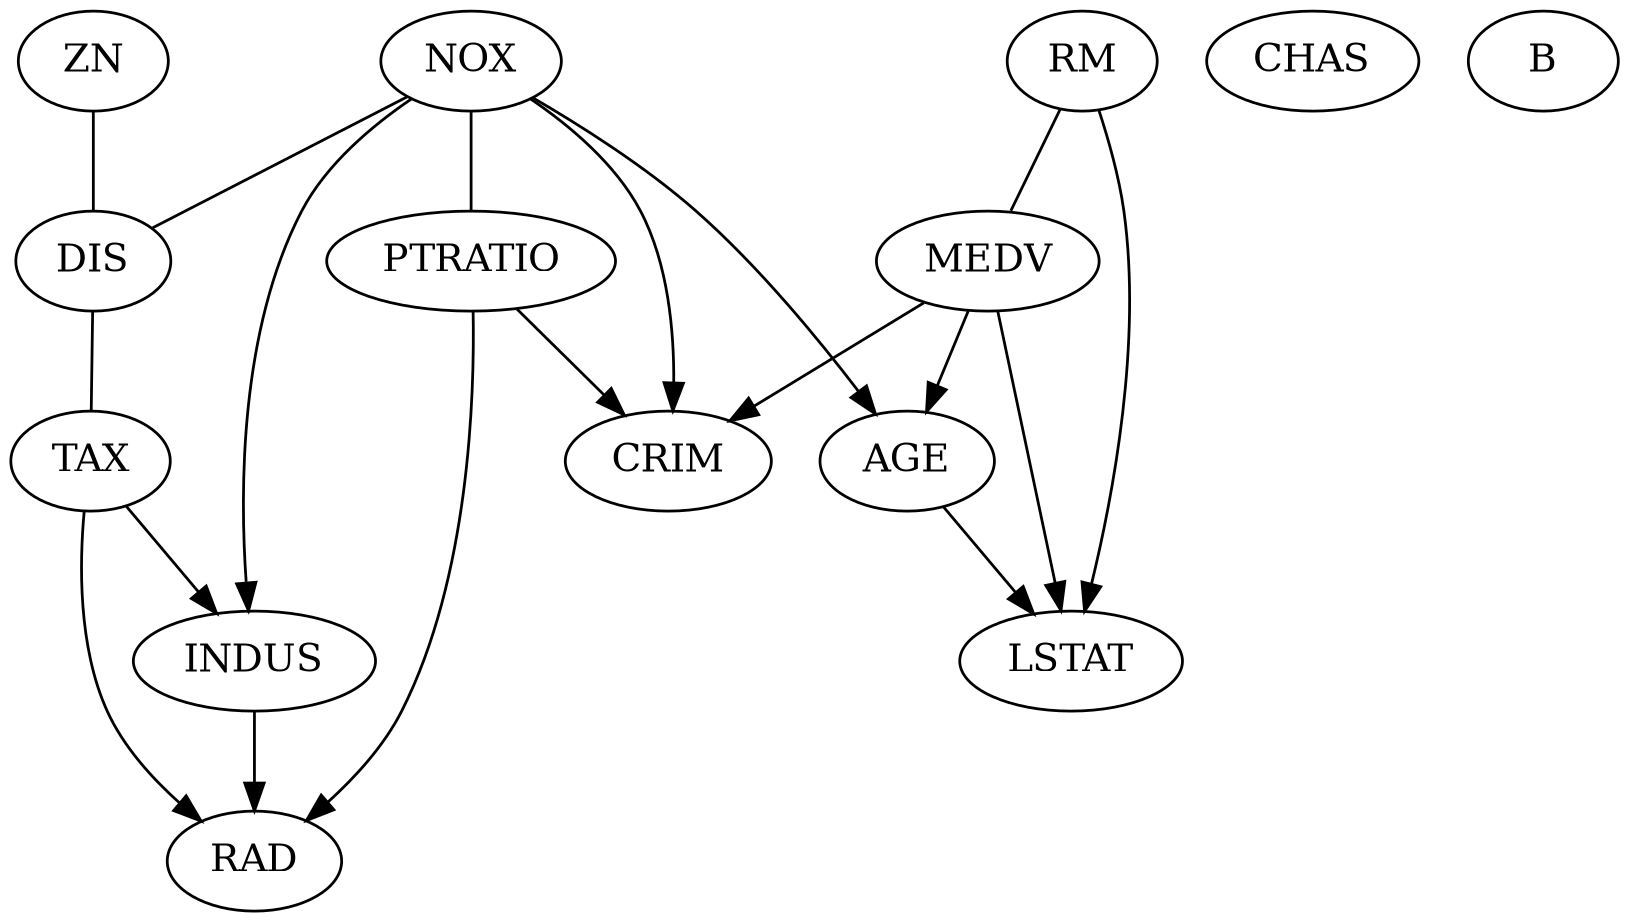

In [5]:
pyd = GraphUtils.to_pydot(cg.G, labels=labels)

# show pyd image
display(Image(pyd.create_png()))

In [6]:
# change gtarph node names 
for i, node in enumerate(cg.G.nodes):
    node.name = labels[i]

In [7]:
# save the node mapping and the reversed mapping
node_mapping = {node.name: index for index, node in enumerate(cg.G.nodes)}
reversed_node_mapping = {index: node.name for index, node in enumerate(cg.G.nodes)}

In [8]:
node_mapping

{'CRIM': 0,
 'ZN': 1,
 'INDUS': 2,
 'CHAS': 3,
 'NOX': 4,
 'RM': 5,
 'AGE': 6,
 'DIS': 7,
 'RAD': 8,
 'TAX': 9,
 'PTRATIO': 10,
 'B': 11,
 'LSTAT': 12,
 'MEDV': 13}

In [9]:
# Now we need to extract the edges:
edges = []
indices = np.where(cg.G.graph != 0)
processed_pairs = set()

for i, j in zip(indices[0], indices[1]):
    
    node_pair = frozenset([i.item(), j.item()])
    
    if node_pair in processed_pairs:
        continue
        
    if cg.G.graph[i,j] == 1 and cg.G.graph[j,i] == -1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "->"
        })
    
    elif cg.G.graph[i,j] == -1 and cg.G.graph[j,i] == -1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "--"
        })
        processed_pairs.add(node_pair) 
    
    elif cg.G.graph[i,j] == 1 and cg.G.graph[j,i] == 1:
        edges.append({
            'from': reversed_node_mapping[i.item()],
            'to': reversed_node_mapping[j.item()],
            'type': "<->"
        })
        processed_pairs.add(node_pair)

for edge in edges:
    print(f"{edge['from']} {edge['type']} {edge['to']}")

CRIM -> NOX
CRIM -> PTRATIO
CRIM -> MEDV
ZN -- DIS
INDUS -> NOX
INDUS -> TAX
NOX -- DIS
NOX -- PTRATIO
RM -- MEDV
AGE -> NOX
AGE -> MEDV
DIS -- TAX
RAD -> INDUS
RAD -> TAX
RAD -> PTRATIO
LSTAT -> RM
LSTAT -> AGE
LSTAT -> MEDV


In [10]:
# create a list of possible causal relationship in the variables
causal_dict = {}
for node1 in node_mapping:
    for node2 in node_mapping:
        for edge in ['direct']:
            causal_dict[(node1, node2, edge)] = len(causal_dict) + 1
            
reversed_causal_dict = {v: k for k, v in causal_dict.items()}

# Now we need to map the edges to the SAT clauses

In [11]:
SATClauses = []

for item in edges:
    if item['type'] == '->':
        # there MUST be a direct edge from node1 to node2 and NO direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([-causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '--':
        # there MUST be exactly one direct edge: either from node1 to node2 OR from node2 to node1 (XOR)
        # For XOR in CNF: (A OR B) AND (NOT A OR NOT B)
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')], causal_dict[(item['to'], item['from'], 'direct')]])
        SATClauses.append([-causal_dict[(item['from'], item['to'], 'direct')], -causal_dict[(item['to'], item['from'], 'direct')]])
    elif item['type'] == '<->':
        # there MUST be a direct edge from node1 to node2 and a direct edge from node2 to node1
        SATClauses.append([causal_dict[(item['from'], item['to'], 'direct')]])
        SATClauses.append([causal_dict[(item['to'], item['from'], 'direct')]])

In [12]:
len(SATClauses)

36

In [13]:
variable_set = set()
for clause in SATClauses:
    for var in clause:
        variable_set.add(abs(var))
        
new_var = list(range(1, len(variable_set) + 1))

# create a mapping from old variable to new variable
cnf_variable_mapping = {}
for i, var in enumerate(variable_set):
    cnf_variable_mapping[var] = new_var[i]
    
# reverse the mapping
reverse_cnf_variable_mapping = {v: k for k, v in cnf_variable_mapping.items()}

# print(f"LOG: The variable mapping is: {cnf_variable_mapping}\n")
# print(f"LOG: The reverse variable mapping is: {reverse_cnf_variable_mapping}\n")

# so the new cnf will be
new_cnf = []
for clause in SATClauses:
    new_clause = []
    for var in clause:
        new_var = cnf_variable_mapping[abs(var)]
        new_clause.append(new_var if var > 0 else -new_var)
    new_cnf.append(new_clause)
    
print(f"LOG: The new CNF is: {new_cnf}\n")

LOG: The new CNF is: [[2], [-18], [5], [-6], [7], [-17], [10, 31], [-10, -31], [11], [-19], [13], [-1], [23, 32], [-23, -32], [24, 8], [-24, -8], [27, 20], [-27, -20], [28], [-22], [30], [-21], [33, 3], [-33, -3], [34], [-12], [35], [-4], [36], [-9], [14], [-26], [15], [-29], [16], [-25]]



In [14]:
# solve the classical SAT
is_sat, model = solveClassicalSAT(new_cnf)

In [15]:
# just to map back the model
temp = []
for item in model:
    temp.append(reverse_cnf_variable_mapping[abs(item)] if item > 0 else -reverse_cnf_variable_mapping[abs(item)])
classical_model = temp

# output the results:
print(f"LOG: Classical SAT solver returned: {is_sat}\n")
print(f"LOG: The model is: {classical_model}\n")

LOG: Classical SAT solver returned: True

LOG: The model is: [-129, 5, 134, -135, 11, -141, 14, 145, -149, 22, 33, -37, 38, 174, 175, 182, -183, -57, -59, 188, -189, -63, 64, -67, -195, -83, -84, 89, -97, 98, -100, -103, -108, 115, 122, 123]



In [16]:
is_sat, quantum_solutions = solveFixedQuantunSAT(new_cnf, 8, np.sqrt(0.1))

LOG: Circuit with 72 qubits
LOG: Too many qubits, aborting


Since there are too many qubits to simulate we're gonna need to use a real quantum hardware. Take into account that right now, Leonardo and other high-performance computers are able to simulate a maximum of 51 qubits.

In [17]:
load_dotenv()
API_KEY = os.getenv("IBM_API_KEY")

QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_KEY, overwrite=True, set_as_default=True)

In [18]:
is_sat, quantum_solutions = solveFixedQuantunSAT(new_cnf, 8, np.sqrt(0.1), simulation=False)

LOG: Circuit with 72 qubits


LOG: Circuit created, circuit depth: 1545
LOG: Running on IBM Quantum Hardware...
Sampler job ID: czsx78dqnmvg008v5ny0


/home/lino/cSAT/venv-3.10/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/lino/cSAT/venv-3.10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lino/cSAT/venv-3.10/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)